In [110]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

import nibabel as nib
import nilearn.plotting as plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import hcp_utils as hcp


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

pd.options.mode.chained_assignment = None  # Hide long warnings

import shap

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import math

In [2]:
file_path = "parcellations"
file_list = os.listdir(file_path)
mmp = [] # Glasser 2016 which partitions each hemisphere into 180 regions
ca = [] # Cole-Anticevic 2019 which further partitions each hemisphere into ~350 regions
for i in file_list:
    if "mmp" in i:
        mmp_file = np.load(file_path + "/" + i)
        if mmp_file.shape == (3600, 379):
            mmp.append(np.load(file_path + "/" + i))

In [3]:
np.load("parcellations/sub-193845_task-rest_parcellation-ca_timeseries.npy").shape

(3600, 718)

In [5]:
open_access_data = pd.read_csv("Behavioral Data/Behavioral_Data.csv")
restricted_data = pd.read_csv("Behavioral Data/RESTRICTED_BEHAVIORAL_DATA.csv")
subject_data = open_access_data.merge(restricted_data, how = 'inner', on = 'Subject')

file_path = "parcellations"
file_list = os.listdir(file_path)
mmp = {}
ca = {}
for filename in file_list:
    subject_id = filename[4:10]

    if subject_id.isdigit():
        subject_id = int(subject_id)

        if "mmp" in filename:
            mmp_file = np.load(file_path + "/" + filename)
            if mmp_file.shape == (3600, 379):
                mmp[subject_id] = mmp_file
        if "ca" in filename:
            ca_file = np.load(file_path + "/" + filename)
            if ca_file.shape == (3600, 718):
                ca[subject_id] = ca_file

mmp_data = pd.DataFrame({
    'Subject': list(mmp.keys()),
    'Brain_Data': list(mmp.values())  # (3600, 379) arrays
})


mmp_data = subject_data.merge(mmp_data, on='Subject', how='inner')

In [6]:
mmp_data.head()

Subject Release Acquisition Gender    Age  3T_Full_MR_Compl  T1_Count  \
0   100610    S900         Q08      M  26-30              True         2   
1   102311    S500         Q06      F  26-30              True         1   
2   102816      Q3         Q03      F  26-30              True         1   
3   104416    S900         Q09      F  31-35              True         2   
4   105923    MEG2         Q07      F  31-35              True         2   

   T2_Count  3T_RS-fMRI_Count  3T_RS-fMRI_PctCompl  ...  \
0         1                 4                100.0  ...   
1         1                 4                100.0  ...   
2         1                 4                100.0  ...   
3         2                 4                100.0  ...   
4         2                 4                100.0  ...   

   SSAGA_Times_Used_Cocaine  SSAGA_Times_Used_Hallucinogens  \
0                       0.0                             0.0   
1                       0.0                             0.0   
2                       0.0                             0.0   
3                       0.0                             0.0   
4                       0.0                             0.0   

   SSAGA_Times_Used_Opiates  SSAGA_Times_Used_Sedatives  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   

   SSAGA_Times_Used_Stimulants  SSAGA_Mj_Use  SSAGA_Mj_Ab_Dep  \
0                          0.0           0.0              0.0   
1                          0.0           0.0              0.0   
2                          0.0           1.0              0.0   
3                          0.0           1.0              0.0   
4                          0.0           1.0              0.0   

   SSAGA_Mj_Age_1st_Use  SSAGA_Mj_Times_Used  \
0                   NaN                  0.0   
1                   NaN                  0.0   
2                   2.0                  3.0   
3                   4.0                  3.0   
4                   4.0                  1.0   

                                          Brain_Data  
0  [[2.3968613, 0.33524948, -0.15465337, 1.955118...  
1  [[-0.13254918, 0.16243707, 0.300286, 0.6371644...  
2  [[0.19969857, -0.7308231, -0.46953073, 0.19398...  
3  [[-0.58722323, -2.054348, -2.3991566, -0.60077...  
4  [[0.4015313, -0.47590375, -0.058990948, -0.747...  

[5 rows x 783 columns]

In [8]:
mmp_data["Handedness_Cat"] = mmp_data["Handedness"].apply(lambda x: 0 if x < 0 else 1)

In [9]:
hand_data = mmp_data[["Subject", "Gender", "Race", "Handedness", "Handedness_Cat"]]
hand_data

Subject Gender                                  Race  Handedness  \
0     100610      M                                 White          85   
1     102311      F                                 White          10   
2     102816      F                  Black or African Am.         100   
3     104416      F  Asian/Nat. Hawaiian/Othr Pacific Is.          65   
4     105923      F                                 White          35   
..       ...    ...                                   ...         ...   
167   943862      M                                 White          95   
168   958976      M                                 White          85   
169   966975      M                                 White          40   
170   971160      M                                 White          80   
171   995174      M                                 White         100   

     Handedness_Cat  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  
..              ...  
167               1  
168               1  
169               1  
170               1  
171               1  

[172 rows x 5 columns]

In [10]:
left_handed = hand_data[hand_data['Handedness'] < 0]
right_handed = hand_data[hand_data['Handedness'] > 0]

# Handedness statistics
pd.DataFrame([
    left_handed.describe()['Handedness'], 
    right_handed.describe()['Handedness'], 
    hand_data['Handedness'].describe()
], index=['Left-Handed', 'Right-Handed', 'Overall']).T

Left-Handed  Right-Handed     Overall
count    13.000000    159.000000  172.000000
mean    -48.846154     79.622642   69.912791
std      34.104853     19.980585   40.129446
min    -100.000000     10.000000 -100.000000
25%     -75.000000     70.000000   65.000000
50%     -40.000000     85.000000   80.000000
75%     -30.000000     95.000000   95.000000
max      -5.000000    100.000000  100.000000

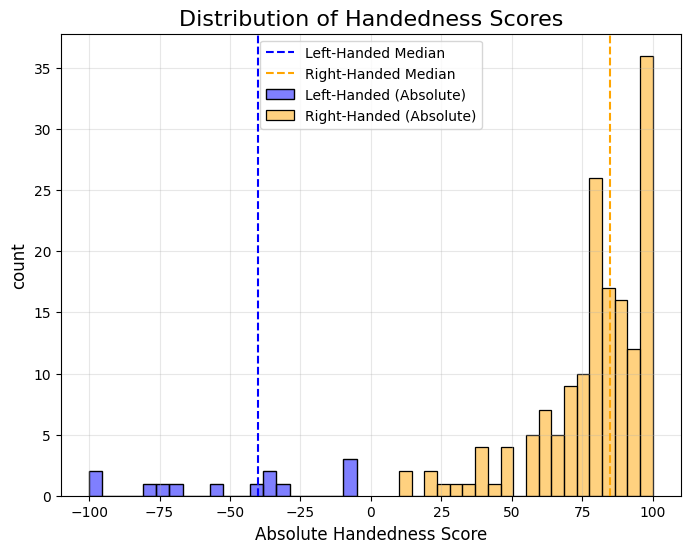

In [14]:
# Take absolute values of Handedness
left_handed_abs = left_handed['Handedness'].abs()
right_handed_abs = right_handed['Handedness'].abs()

plt.figure(figsize=(8, 6))
sns.histplot(left_handed['Handedness'], color='blue', label='Left-Handed (Absolute)', kde=False, bins=20, alpha=0.5)
sns.histplot(right_handed['Handedness'], color='orange', label='Right-Handed (Absolute)', kde=False, bins=20, alpha=0.5)


# mark medians
plt.axvline(left_handed['Handedness'].median(), color='blue', linestyle='--', label='Left-Handed Median')
plt.axvline(right_handed['Handedness'].median(), color='orange', linestyle='--', label='Right-Handed Median')

# Labels and title
plt.xlabel('Absolute Handedness Score', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title('Distribution of Handedness Scores', fontsize=16)
plt.legend()

plt.grid(alpha=0.3)
plt.show()

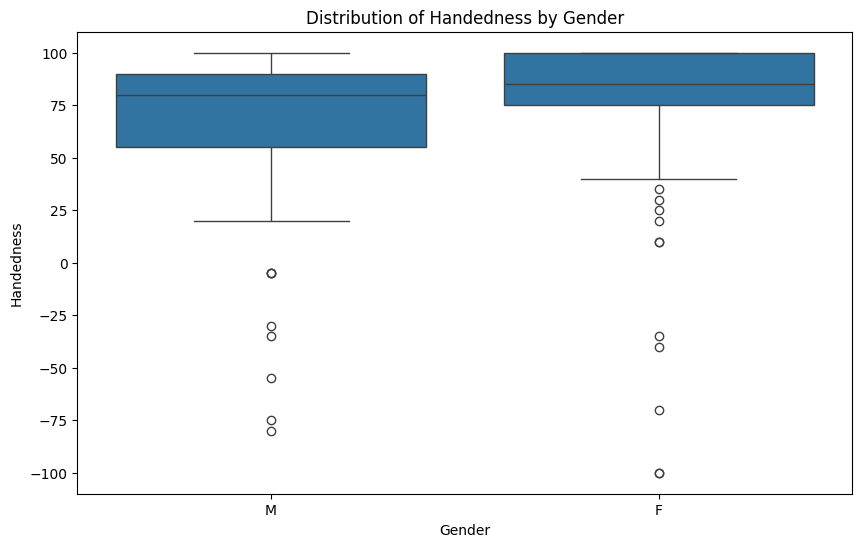

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=hand_data, x='Gender', y='Handedness')
plt.title("Distribution of Handedness by Gender")
plt.xlabel("Gender")
plt.ylabel("Handedness")
plt.show()

In [15]:
mmp_correlation_matrix_list = []
for i in range(mmp_data.shape[0]):
    person = mmp_data["Brain_Data"][i]
    #get matrix
    person_matrix = np.corrcoef(person.T)
    #append to list
    mmp_correlation_matrix_list.append(person_matrix)
#append to column
mmp_data["correlation_matrix"] = mmp_correlation_matrix_list

In [17]:
mmp_data['correlation_matrix']

0      [[1.0, 0.46619928616491757, 0.5387587799680043...
1      [[1.0, 0.4145113094959292, 0.342818966658749, ...
2      [[0.9999999999999998, 0.2989986241314227, 0.52...
3      [[0.9999999999999998, 0.5081583697070787, 0.59...
4      [[1.0, 0.5963831451011642, 0.6588621195832001,...
                             ...                        
167    [[1.0, 0.5868952668034533, 0.6650024441927097,...
168    [[1.0, 0.2527353927273103, 0.6220543671787876,...
169    [[1.0, 0.4077766140820082, 0.5679625164532214,...
170    [[0.9999999999999998, 0.4373132861456234, 0.65...
171    [[1.0, 0.1745251119720137, 0.5239475526043362,...
Name: correlation_matrix, Length: 172, dtype: object

In [19]:
mmp_regions = list(hcp.mmp.labels.values())
hcp.mmp.labels

{np.int64(0): np.str_(''),
 np.int64(1): np.str_('L_V1'),
 np.int64(2): np.str_('L_MST'),
 np.int64(3): np.str_('L_V6'),
 np.int64(4): np.str_('L_V2'),
 np.int64(5): np.str_('L_V3'),
 np.int64(6): np.str_('L_V4'),
 np.int64(7): np.str_('L_V8'),
 np.int64(8): np.str_('L_4'),
 np.int64(9): np.str_('L_3b'),
 np.int64(10): np.str_('L_FEF'),
 np.int64(11): np.str_('L_PEF'),
 np.int64(12): np.str_('L_55b'),
 np.int64(13): np.str_('L_V3A'),
 np.int64(14): np.str_('L_RSC'),
 np.int64(15): np.str_('L_POS2'),
 np.int64(16): np.str_('L_V7'),
 np.int64(17): np.str_('L_IPS1'),
 np.int64(18): np.str_('L_FFC'),
 np.int64(19): np.str_('L_V3B'),
 np.int64(20): np.str_('L_LO1'),
 np.int64(21): np.str_('L_LO2'),
 np.int64(22): np.str_('L_PIT'),
 np.int64(23): np.str_('L_MT'),
 np.int64(24): np.str_('L_A1'),
 np.int64(25): np.str_('L_PSL'),
 np.int64(26): np.str_('L_SFL'),
 np.int64(27): np.str_('L_PCV'),
 np.int64(28): np.str_('L_STV'),
 np.int64(29): np.str_('L_7Pm'),
 np.int64(30): np.str_('L_7m'),
 np

In [18]:
hcp.view_parcellation(hcp.mesh.inflated, hcp.mmp)

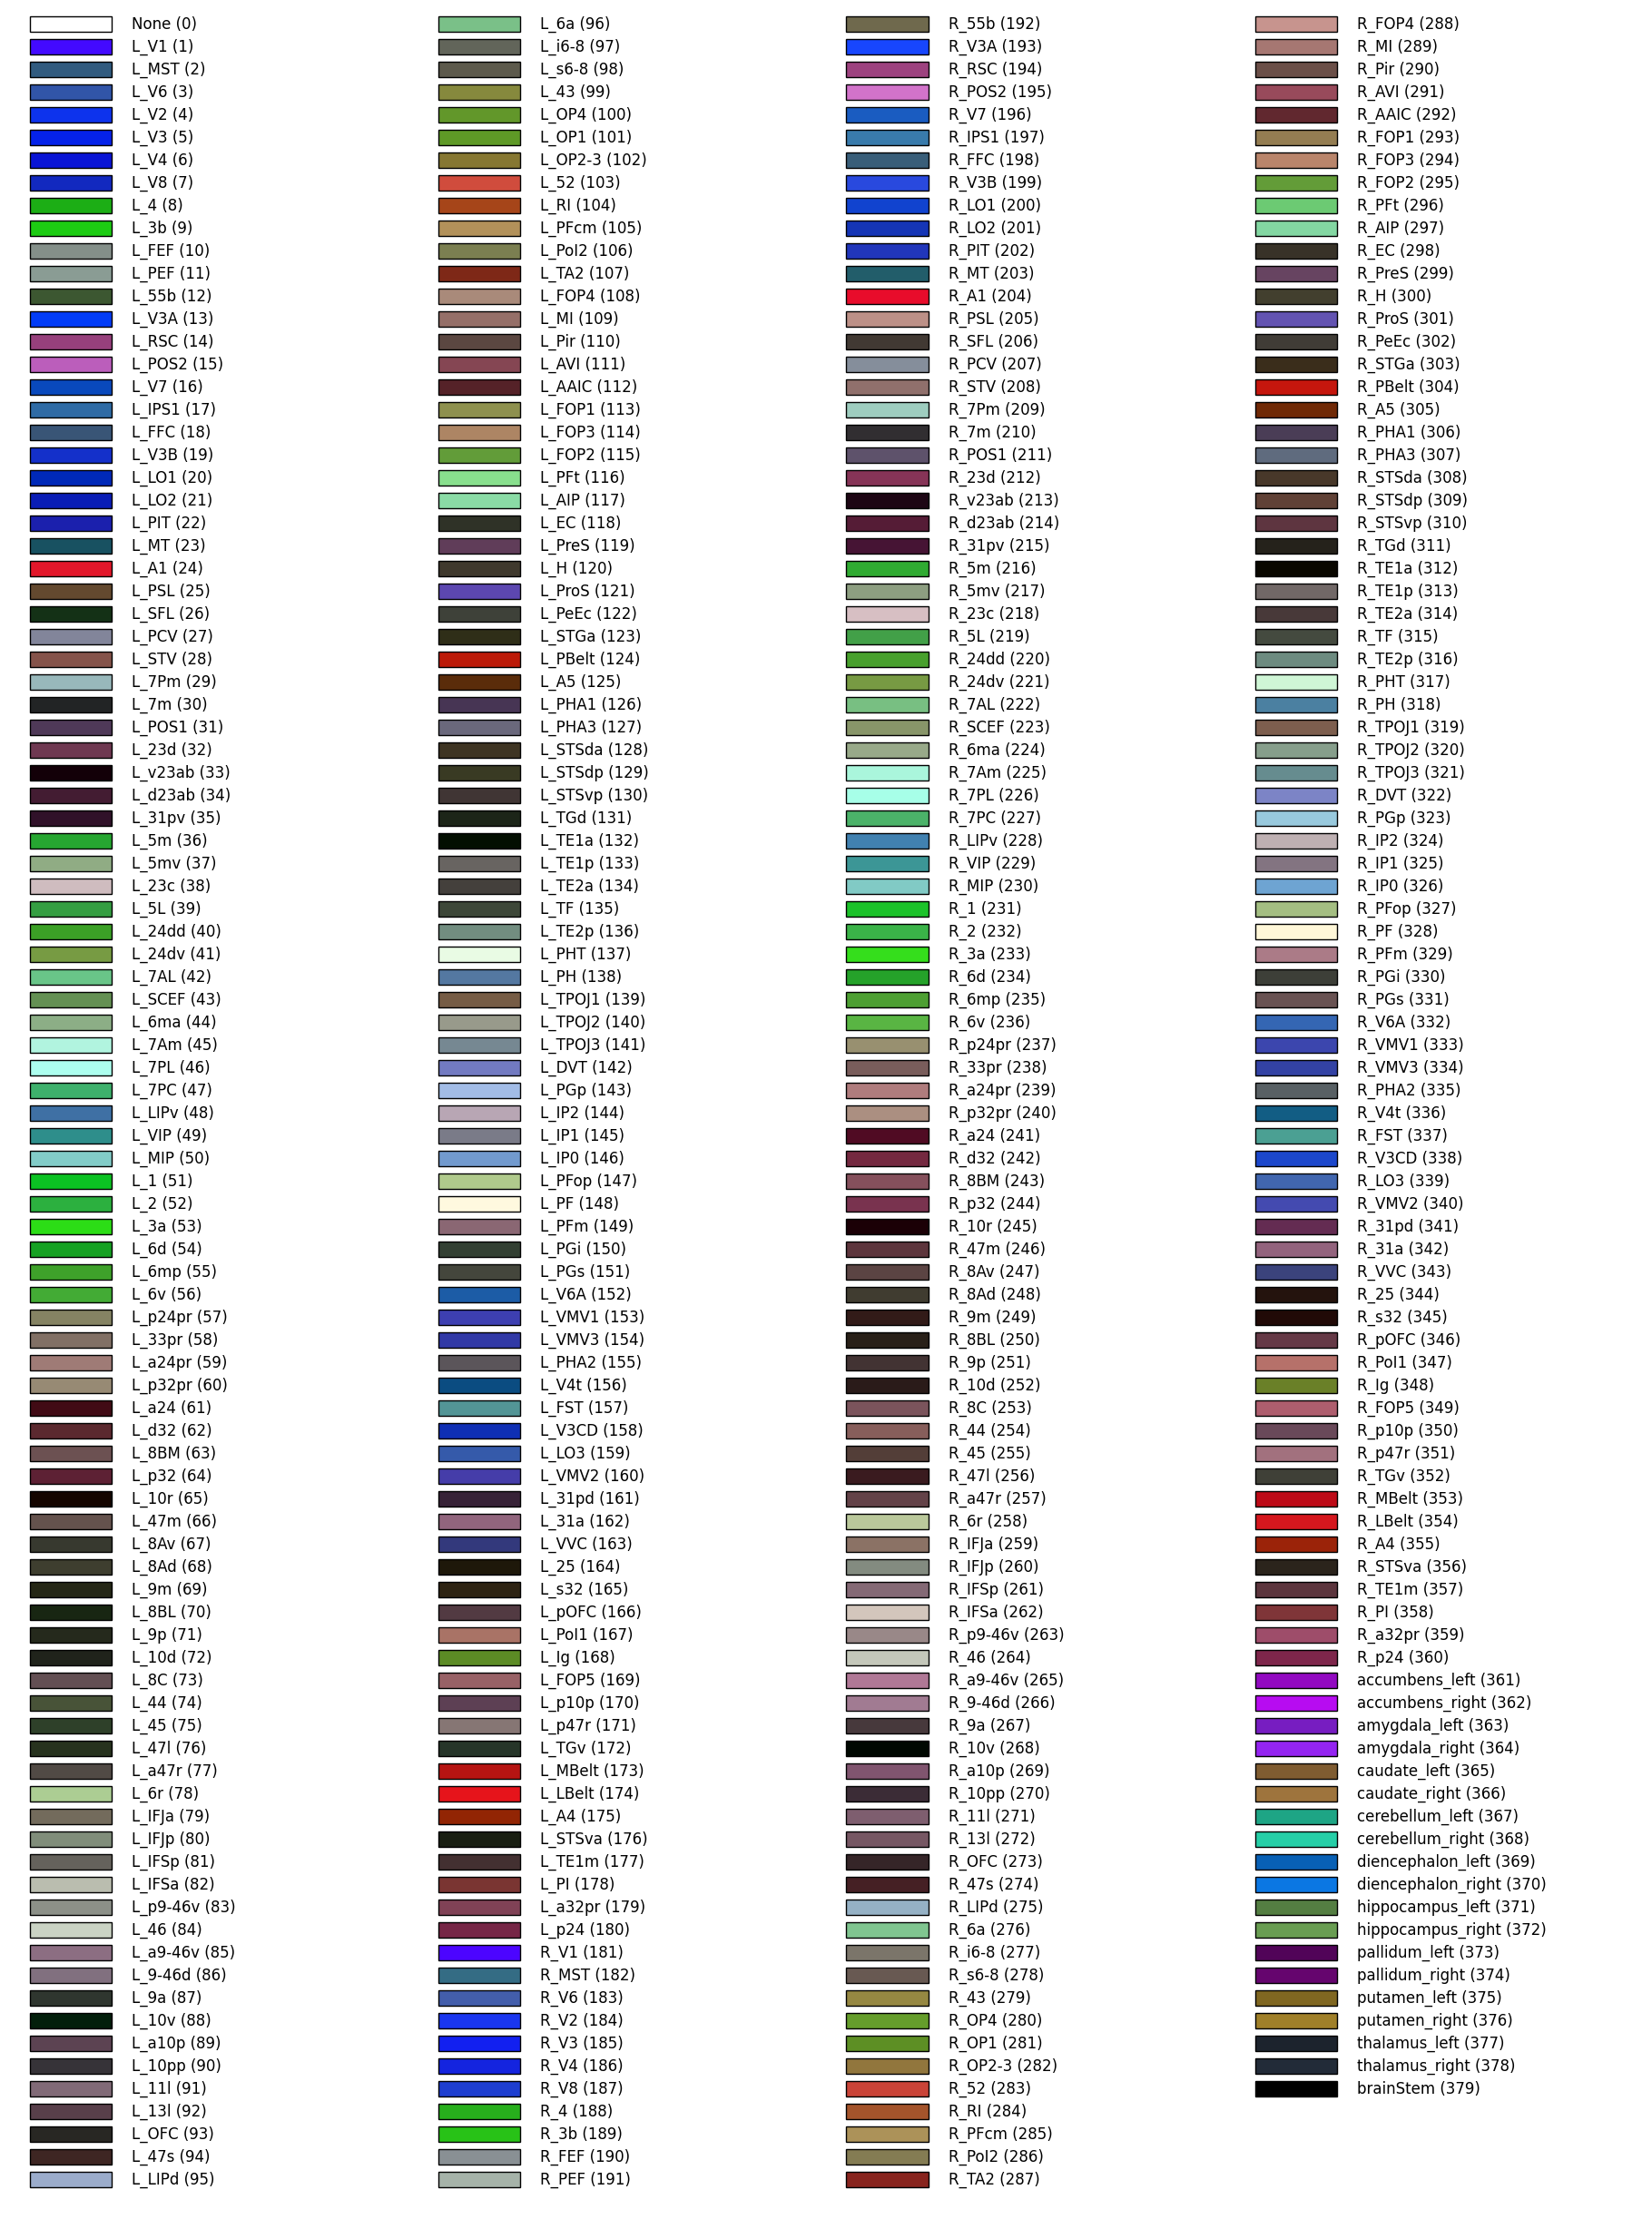

In [32]:
hcp.parcellation_labels(hcp.mmp)

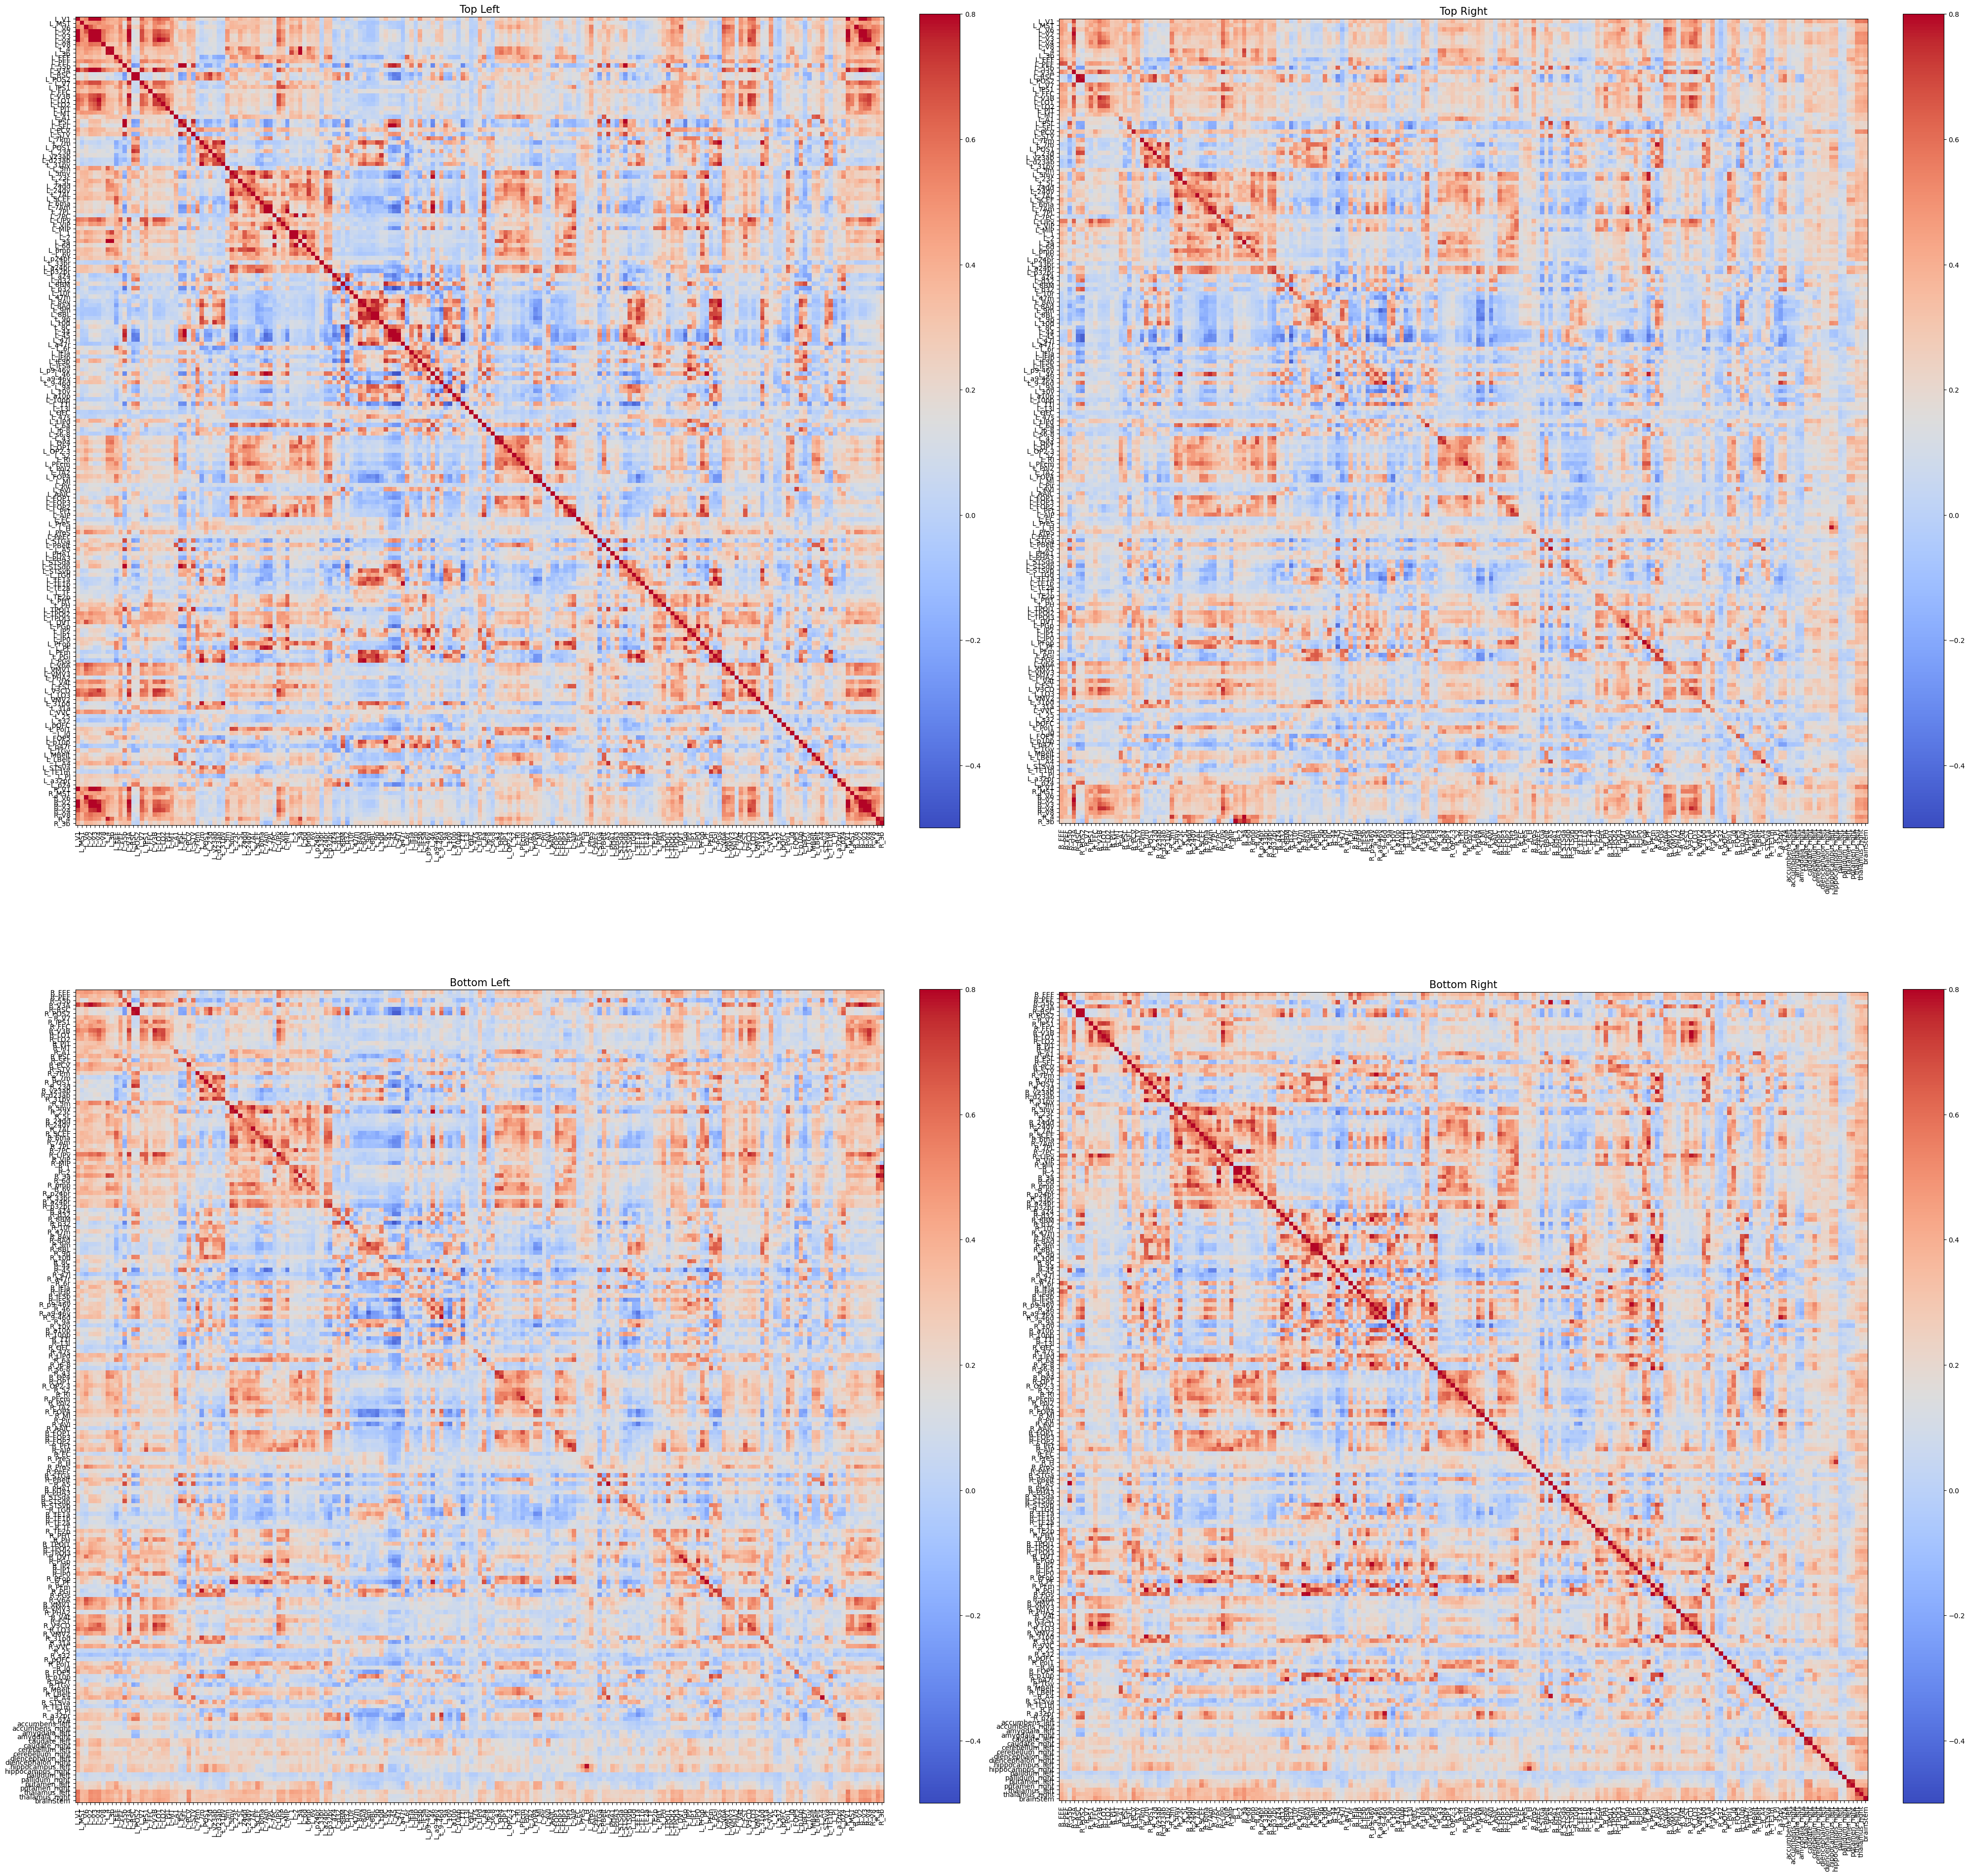

In [30]:
# Get the **first** correlation matrix to see for example
matrix = mmp_correlation_matrix_list[0]
labels = mmp_regions[1:] # mmp_regions[0] is just np.str_(''), leave it

# Define size of each quadrant
n = len(labels)  
half_n = n // 2  # Halfway point to split

fig, axes = plt.subplots(2, 2, figsize=(40, 40))

def plot_quadrant(ax, data, x_labels, y_labels, title):
    im = ax.imshow(data, cmap="coolwarm", vmin=-0.5, vmax=0.8)
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_xticklabels(x_labels, fontsize=10, rotation=90)
    ax.set_yticklabels(y_labels, fontsize=10)
    ax.set_title(title, fontsize=15)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Add colorbar

# Top-left quadrant
plot_quadrant(axes[0, 0], matrix[:half_n, :half_n], labels[:half_n], labels[:half_n], "Top Left")

# Top-right quadrant
plot_quadrant(axes[0, 1], matrix[:half_n, half_n:], labels[half_n:], labels[:half_n], "Top Right")

# Bottom-left quadrant
plot_quadrant(axes[1, 0], matrix[half_n:, :half_n], labels[:half_n], labels[half_n:], "Bottom Left")

# Bottom-right quadrant
plot_quadrant(axes[1, 1], matrix[half_n:, half_n:], labels[half_n:], labels[half_n:], "Bottom Right")

plt.tight_layout()
plt.show()

In [38]:
# Dictionary to store sum of correlation values and count occurrences across subjects
pairwise_corr = {}

# Iterate over all correlation matrices (subjects)
for matrix in mmp_correlation_matrix_list:
    # Get the upper triangle of the matrix, excluding the diagonal
    triu_indices = np.triu_indices_from(matrix, k=1)
    values = matrix[triu_indices]

    # Get the region name pairs
    region_pairs = [(mmp_regions[i + 1], mmp_regions[j + 1]) for i, j in zip(*triu_indices)]

    # Create a DataFrame for sorting
    df = pd.DataFrame({
        "Region 1": [pair[0] for pair in region_pairs],
        "Region 2": [pair[1] for pair in region_pairs],
        "Correlation": values
    })

    # Sort by absolute correlation value (consider both positive and negative)
    df_sorted = df.sort_values(by="Correlation", ascending=False)
    
    # Select top 15 most positive and top 15 most negative correlations
    top_positive = df_sorted.head(15)
    top_negative = df_sorted.tail(15)  # Tail gets the most negative correlations

    # Combine both selections
    top_30 = pd.concat([top_positive, top_negative])

    # Aggregate correlation values for each region pair
    for _, row in top_30.iterrows():
        pair = (row["Region 1"], row["Region 2"])
        if pair not in pairwise_corr:
            pairwise_corr[pair] = {"sum": 0, "count": 0}
        pairwise_corr[pair]["sum"] += row["Correlation"]
        pairwise_corr[pair]["count"] += 1

# Compute average correlation values for each region pair
avg_corr_list = [
    {"Region 1": pair[0], "Region 2": pair[1], "Average Correlation": pairwise_corr[pair]["sum"] / pairwise_corr[pair]["count"]}
    for pair in pairwise_corr
]

# Convert to DataFrame and sort by absolute average correlation
df_avg_corr = pd.DataFrame(avg_corr_list).sort_values(by="Average Correlation", ascending=False)

# Select the final top 30 region pairs with highest absolute average correlation
final_top_30 = df_avg_corr.head(30)

# Display the results
print(final_top_30)

     Region 1 Region 2  Average Correlation
0        L_V1     R_V1             0.954988
1098     L_A4     R_A4             0.954090
1        L_V2     R_V2             0.942734
898     L_FFC    R_FFC             0.936894
865      L_V3     R_V1             0.927494
866      R_V1     R_V3             0.926878
540       L_1      R_2             0.924642
234      L_3b      R_1             0.922932
2        L_V2     L_V3             0.921081
415       L_4     R_3a             0.919865
578     L_SFL    R_SFL             0.919701
329     L_FEF    R_FEF             0.918987
113      L_3a      R_4             0.917899
199      R_9m     R_9p             0.916732
70        L_4     L_3a             0.916438
197      L_3b      L_1             0.916279
1016      L_4     L_3b             0.916278
11      L_V3A    R_V3A             0.915702
30       L_V3     R_V3             0.915024
69       L_3a     R_3a             0.913762
1067      L_1     R_3b             0.913597
36       L_V4     R_V4          

strong bilateral symmetry in primary sensory, motor (L_4, R_4, L_1, R_1), and visual areas (L_V1, R_V1, L_V2, R_V2)
* the most correlated regions are not highly lateralized. 
* Since handedness is based on asymmetries in motor and prefrontal regions, these strong bilateral connections may not be the best predictors. 
* Try ca data and see if it has asymmetrical motor (M1, PMd, SMA) and association areas to improve classification accuracy.

In [46]:
handedness_regions = [
    # 1. Primary Motor & Somatosensory Cortex
    "L_4", "R_4",  # Primary Motor Cortex (M1)
    "L_1", "L_2", "L_3a", "R_1", "R_2", "R_3a",  # Somatosensory Cortex (S1)
    "L_3b", "R_3b",  # Secondary Somatosensory Cortex

    # 2. Premotor & Supplementary Motor Areas (SMA, PMd, PMv)
    "L_6mp", "R_6mp",  # Supplementary Motor Area (SMA)
    "L_6ma", "R_6ma",  # Medial Premotor Cortex
    "L_6d", "R_6d",  # Dorsal Premotor Cortex (PMd) - Reach, grasp control
    "L_6r", "R_6r",  # Rostral Premotor Cortex - Higher-order motor control
    "L_6a", "R_6a",  # Anterior Premotor Cortex
    "L_FEF", "R_FEF",  # Frontal Eye Fields (FEF) - Eye-hand coordination
    "L_6v", "R_6v", # Ventral Premotor Cortex (PMv), crucial for movement execution"

    # 3. Parietal Cortex & Sensorimotor Integration
    "L_IPS1", "R_IPS1",  # Intraparietal Sulcus (IPS) - Sensorimotor integration
    "L_LIPv", "R_LIPv",
    "L_LIPd", "R_LIPd",
    "L_7AL", "R_7AL",  # Superior Parietal Lobule (SPL) - Hand coordination
    "L_7m", "R_7m",
    "L_7PC", "R_7PC",

    # 4. Corpus Callosum & Interhemispheric Connections
    "L_31pv", "R_31pv",
    "L_31pd", "R_31pd",
    "L_24dd", "R_24dd",  # Dorsal Anterior Cingulate Cortex - Motor learning
    "L_24dv", "R_24dv",  # Ventral Anterior Cingulate Cortex

    # 6. Prefrontal Cortex (Executive & Motor Control)
    "L_9-46d", "R_9-46d",  # Dorsolateral Prefrontal Cortex (DLPFC) - Movement decision-making
    "L_46", "R_46",
    "L_44", "R_44",  # Broca's area - Language-motor integration
    "L_45", "R_45",

    # 7. Additional Relevant Motor Control Regions
    "L_SCEF", "R_SCEF",  # Supplementary & Cingulate Eye Fields
    "L_MIP", "R_MIP",  # Medial Intraparietal - Reach planning
    "L_VIP", "R_VIP",  # Ventral Intraparietal - Visuomotor integration
    
    # 8. Subcortical Motor-related Areas
    "putamen_left", "putamen_right",
    "caudate_left", "caudate_right",
    "thalamus_left", "thalamus_right",
    "cerebellum_left", "cerebellum_right",

    # 9. Brainstem - Motor relay
    "brainStem"
]


In [42]:
mmp_regions = mmp_regions[1:]
mmp_regions

[np.str_('L_V1'),
 np.str_('L_MST'),
 np.str_('L_V6'),
 np.str_('L_V2'),
 np.str_('L_V3'),
 np.str_('L_V4'),
 np.str_('L_V8'),
 np.str_('L_4'),
 np.str_('L_3b'),
 np.str_('L_FEF'),
 np.str_('L_PEF'),
 np.str_('L_55b'),
 np.str_('L_V3A'),
 np.str_('L_RSC'),
 np.str_('L_POS2'),
 np.str_('L_V7'),
 np.str_('L_IPS1'),
 np.str_('L_FFC'),
 np.str_('L_V3B'),
 np.str_('L_LO1'),
 np.str_('L_LO2'),
 np.str_('L_PIT'),
 np.str_('L_MT'),
 np.str_('L_A1'),
 np.str_('L_PSL'),
 np.str_('L_SFL'),
 np.str_('L_PCV'),
 np.str_('L_STV'),
 np.str_('L_7Pm'),
 np.str_('L_7m'),
 np.str_('L_POS1'),
 np.str_('L_23d'),
 np.str_('L_v23ab'),
 np.str_('L_d23ab'),
 np.str_('L_31pv'),
 np.str_('L_5m'),
 np.str_('L_5mv'),
 np.str_('L_23c'),
 np.str_('L_5L'),
 np.str_('L_24dd'),
 np.str_('L_24dv'),
 np.str_('L_7AL'),
 np.str_('L_SCEF'),
 np.str_('L_6ma'),
 np.str_('L_7Am'),
 np.str_('L_7PL'),
 np.str_('L_7PC'),
 np.str_('L_LIPv'),
 np.str_('L_VIP'),
 np.str_('L_MIP'),
 np.str_('L_1'),
 np.str_('L_2'),
 np.str_('L_3a'),
 

In [43]:
def feature_row_get(target):
    target_index = mmp_regions.index(target)
    target_row = mmp_data['correlation_matrix'].apply(lambda x: x[target_index])
    
    return target_row


In [44]:
# Function to extract features automatically
def extract_features(region_list, data):
    """
    Extracts the correlation matrix rows for each brain region in region_list.
    
    Parameters:
    - region_list: List of brain region names (e.g., ["L_MT", "L_4", "R_4"])
    - data: DataFrame containing "correlation_matrix"
    
    Returns:
    - DataFrame with extracted features
    """
    # Copy the relevant columns first
    feature_data = data[["Handedness", "Handedness_Cat", "correlation_matrix"]].copy()

    # Compute the mean of the entire correlation matrix as a baseline feature
    feature_data["matrix_mean"] = data["correlation_matrix"].apply(lambda x: np.mean(x))

    # Apply feature_row_get() dynamically and store in a dictionary
    for region in region_list:
        feature_data[region] = feature_row_get(region)

    return feature_data


In [86]:
# Extract features for handedness prediction
feature_data = extract_features(handedness_regions, mmp_data)
feature_data

Handedness  Handedness_Cat  \
0            85               1   
1            10               1   
2           100               1   
3            65               1   
4            35               1   
..          ...             ...   
167          95               1   
168          85               1   
169          40               1   
170          80               1   
171         100               1   

                                    correlation_matrix  matrix_mean  \
0    [[1.0, 0.46619928616491757, 0.5387587799680043...     0.175993   
1    [[1.0, 0.4145113094959292, 0.342818966658749, ...     0.186351   
2    [[0.9999999999999998, 0.2989986241314227, 0.52...     0.258471   
3    [[0.9999999999999998, 0.5081583697070787, 0.59...     0.211318   
4    [[1.0, 0.5963831451011642, 0.6588621195832001,...     0.327927   
..                                                 ...          ...   
167  [[1.0, 0.5868952668034533, 0.6650024441927097,...     0.368026   
168  [[1.0, 0.2527353927273103, 0.6220543671787876,...     0.230883   
169  [[1.0, 0.4077766140820082, 0.5679625164532214,...     0.466140   
170  [[0.9999999999999998, 0.4373132861456234, 0.65...     0.312844   
171  [[1.0, 0.1745251119720137, 0.5239475526043362,...     0.213796   

                                                   L_4  \
0    [0.44603460807054096, 0.4180526599268045, 0.49...   
1    [-0.03625874806779633, 0.3554951523299754, 0.5...   
2    [0.2557007884462401, 0.4163673796361299, 0.587...   
3    [0.4339877528645952, 0.5040271371932618, 0.628...   
4    [0.45387901174031836, 0.5127461328419858, 0.57...   
..                                                 ...   
167  [0.4335314903127061, 0.49358735347989097, 0.48...   
168  [0.35354789580419377, 0.3163732766286689, 0.47...   
169  [0.30593705191886855, 0.7084277311272105, 0.61...   
170  [0.4930544377375701, 0.44600991439914045, 0.63...   
171  [0.2729814533817979, 0.32042381394641656, 0.38...   

                                                   R_4  \
0    [0.5058448287380618, 0.4015377697499112, 0.512...   
1    [-0.10786685793218385, 0.30606096530910526, 0....   
2    [0.3319607392943346, 0.4335608090685443, 0.660...   
3    [0.37742673354089434, 0.4739060736846943, 0.60...   
4    [0.4722164765751269, 0.5332245212475473, 0.588...   
..                                                 ...   
167  [0.46757114407113437, 0.49559502463398847, 0.5...   
168  [0.3833644603082186, 0.3125027061924907, 0.472...   
169  [0.2893851044912467, 0.7092175535808757, 0.601...   
170  [0.5014488388582563, 0.4356866869800902, 0.635...   
171  [0.20939550591046974, 0.354066608707843, 0.351...   

                                                   L_1  \
0    [0.40548299302723256, 0.3255226507827946, 0.46...   
1    [0.1866388091202092, 0.5719445130192548, 0.707...   
2    [0.30591984028492586, 0.3901975349387497, 0.58...   
3    [0.3937560464391664, 0.5432009909529222, 0.607...   
4    [0.45131751729769015, 0.6203443289412882, 0.62...   
..                                                 ...   
167  [0.3814659886450934, 0.48637599747041455, 0.49...   
168  [0.46356821240382845, 0.3616333209016325, 0.47...   
169  [0.33420252438111026, 0.7537192574490216, 0.64...   
170  [0.46300169231733235, 0.40169308968474127, 0.5...   
171  [0.2673637885528485, 0.40869900411909427, 0.43...   

                                                   L_2  \
0    [0.3554718317313472, 0.25483166802262797, 0.36...   
1    [0.2012457043420382, 0.535342102420762, 0.6948...   
2    [0.325970189999188, 0.40499778505999673, 0.534...   
3    [0.40808604943560123, 0.5336622651926306, 0.59...   
4    [0.47605793011712233, 0.6169004247170177, 0.63...   
..                                                 ...   
167  [0.43989069833193567, 0.5640119282654538, 0.53...   
168  [0.41832663763538885, 0.3944112191816565, 0.46...   
169  [0.3153725803019104, 0.7595794853273243, 0.640...   
170  [0.5148122187550437, 0.4317223912458006, 0.607...   
17

In [48]:
def flatten_features(row, region_list):
    """
    Flattens selected brain region features into a single numpy array.
    
    Parameters:
    - row: A single row from the DataFrame
    - region_list: List of selected brain regions
    
    Returns:
    - 1D numpy array containing all extracted feature values
    """
    # Flatten the correlation matrix (if applicable)
    corr_mat = np.array(row["correlation_matrix"]).flatten()

    # Extract all relevant region values dynamically
    region_values = [np.array(row[region]) for region in region_list if region in row]

    # Concatenate into one feature array
    return np.concatenate(region_values)


In [87]:
feature_data_all = feature_data.copy()

In [88]:
filtered_df = feature_data[(feature_data['Handedness'] > 25) | (feature_data['Handedness'] < -25)]
feature_data = filtered_df
feature_data.shape

(164, 71)

could do random sampling of the right-handed group, but data size is too small

In [89]:
# Separate into left and right handed
left_handed = filtered_df[filtered_df['Handedness'] < 0]
right_handed = filtered_df[filtered_df['Handedness'] > 0]
print(left_handed.shape, right_handed.shape)

# Determine the number of samples to select from the right-handed data
num_samples = min(len(left_handed), len(right_handed))

# Randomly sample from the right-handed data
right_handed_sample = right_handed.sample(n=num_samples, random_state=42)

# Combine the left and right handed data
df_sampled = pd.concat([left_handed, right_handed_sample])
df_sampled.shape

# feature_data = df_sampled
# feature_data.shape

(10, 71) (154, 71)


(20, 71)

In [104]:
def SVM_w_sampling (sampling_method):

    test_result = []
    trial_ci = []
    trial_acc = []

    for i in range(5):
        # Feature extraction
        X_list = feature_data.apply(lambda row: flatten_features(row, handedness_regions), axis=1)
        X = np.vstack(X_list.values)  # Convert to a 2D NumPy array
        y = feature_data["Handedness_Cat"]

        # Train-Test Split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.4, stratify=None  # More variation by setting stratify=None
        )
        
        print(f"Run {i+1}: Before Oversampling - {Counter(y_train)}")

        # Determine the smallest class count
        min_class_count = min(Counter(y_train).values())

        # Set k_neighbors dynamically (must be < min_class_count)
        k_neighbors = max(1, min(5, min_class_count - 1))  # Ensure k_neighbors is valid

        # Apply oversampling only on the training set
        if sampling_method == "SMOTE":
            sampler = SMOTE(k_neighbors=k_neighbors, random_state=None)
        elif sampling_method == "ADASYN":
            sampler = ADASYN(n_neighbors=k_neighbors, random_state=None)
        elif sampling_method == 'RandomUnderSampler':
            sampler = RandomUnderSampler(random_state=None)
        elif sampling_method == 'RandomOverSampler':
            sampler = RandomOverSampler(random_state=None)

        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

        print(f"After Oversampling - {Counter(y_train_resampled)}")

        # Train SVM Model
        model_class = Pipeline([
            ("scaler", StandardScaler()),
            ("svc", SVC(kernel="rbf", probability=True, C=1.0, class_weight="balanced"))
        ])
        model_class.fit(X_train_resampled, y_train_resampled)
        y_pred = model_class.predict(X_test)

        # Balanced Accuracy & Confusion Matrix
        accuracy = accuracy_score(y_test, y_pred)
        balanced_acc = balanced_accuracy_score(y_test, y_pred) 
        conf_matrix = confusion_matrix(y_test, y_pred)

        print(f"Accuracy: {accuracy:.4f}, Balanced Accuracy: {balanced_acc:.4f}")
        print("Confusion Matrix:\n", conf_matrix)

        # 95% Confidence Interval Calculation
        n_test = len(y_test)
        z_value = 1.96  # for ~95% CI
        std_error = math.sqrt(accuracy * (1 - accuracy) / n_test)

        ci_lower = accuracy - z_value * std_error
        ci_upper = accuracy + z_value * std_error

        print(f"95% CI for Accuracy: [{ci_lower:.4f}, {ci_upper:.4f}]")

        # Store results
        trial_ci.append([ci_lower, ci_upper])
        trial_acc.append(balanced_acc)
        test_result.append(accuracy)

    # Final Results
    print(f"Final Average Accuracy: {np.mean(test_result):.4f}")
    print(f"Final Average Balanced Accuracy: {np.mean(trial_acc):.4f}")

In [105]:
SVM_w_sampling('SMOTE')

Run 1: Before Oversampling - Counter({1: 89, 0: 9})
After Oversampling - Counter({1: 89, 0: 89})
Accuracy: 0.9848, Balanced Accuracy: 0.5000
Confusion Matrix:
 [[ 0  1]
 [ 0 65]]
95% CI for Accuracy: [0.9554, 1.0143]
Run 2: Before Oversampling - Counter({1: 91, 0: 7})
After Oversampling - Counter({1: 91, 0: 91})
Accuracy: 0.9545, Balanced Accuracy: 0.5000
Confusion Matrix:
 [[ 0  3]
 [ 0 63]]
95% CI for Accuracy: [0.9043, 1.0048]
Run 3: Before Oversampling - Counter({1: 91, 0: 7})
After Oversampling - Counter({1: 91, 0: 91})
Accuracy: 0.9545, Balanced Accuracy: 0.5000
Confusion Matrix:
 [[ 0  3]
 [ 0 63]]
95% CI for Accuracy: [0.9043, 1.0048]
Run 4: Before Oversampling - Counter({1: 92, 0: 6})
After Oversampling - Counter({1: 92, 0: 92})
Accuracy: 0.9394, Balanced Accuracy: 0.5000
Confusion Matrix:
 [[ 0  4]
 [ 0 62]]
95% CI for Accuracy: [0.8818, 0.9970]
Run 5: Before Oversampling - Counter({1: 92, 0: 6})
After Oversampling - Counter({1: 92, 0: 92})
Accuracy: 0.9394, Balanced Accuracy

In [107]:
SVM_w_sampling('ADASYN')

Run 1: Before Oversampling - Counter({1: 92, 0: 6})
After Oversampling - Counter({0: 93, 1: 92})
Accuracy: 0.9394, Balanced Accuracy: 0.5000
Confusion Matrix:
 [[ 0  4]
 [ 0 62]]
95% CI for Accuracy: [0.8818, 0.9970]
Run 2: Before Oversampling - Counter({1: 90, 0: 8})
After Oversampling - Counter({1: 90, 0: 88})
Accuracy: 0.9697, Balanced Accuracy: 0.5000
Confusion Matrix:
 [[ 0  2]
 [ 0 64]]
95% CI for Accuracy: [0.9283, 1.0111]
Run 3: Before Oversampling - Counter({1: 92, 0: 6})
After Oversampling - Counter({1: 92, 0: 92})
Accuracy: 0.9394, Balanced Accuracy: 0.5000
Confusion Matrix:
 [[ 0  4]
 [ 0 62]]
95% CI for Accuracy: [0.8818, 0.9970]
Run 4: Before Oversampling - Counter({1: 93, 0: 5})
After Oversampling - Counter({0: 95, 1: 93})
Accuracy: 0.9242, Balanced Accuracy: 0.5000
Confusion Matrix:
 [[ 0  5]
 [ 0 61]]
95% CI for Accuracy: [0.8604, 0.9881]
Run 5: Before Oversampling - Counter({1: 90, 0: 8})
After Oversampling - Counter({0: 93, 1: 90})
Accuracy: 0.9697, Balanced Accuracy

In [108]:
SVM_w_sampling('RandomUnderSampler')

Run 1: Before Oversampling - Counter({1: 93, 0: 5})
After Oversampling - Counter({0: 5, 1: 5})
Accuracy: 0.6667, Balanced Accuracy: 0.6361
Confusion Matrix:
 [[ 3  2]
 [20 41]]
95% CI for Accuracy: [0.5529, 0.7804]
Run 2: Before Oversampling - Counter({1: 94, 0: 4})
After Oversampling - Counter({0: 4, 1: 4})
Accuracy: 0.6667, Balanced Accuracy: 0.5917
Confusion Matrix:
 [[ 3  3]
 [19 41]]
95% CI for Accuracy: [0.5529, 0.7804]
Run 3: Before Oversampling - Counter({1: 91, 0: 7})
After Oversampling - Counter({0: 7, 1: 7})
Accuracy: 0.5303, Balanced Accuracy: 0.5952
Confusion Matrix:
 [[ 2  1]
 [30 33]]
95% CI for Accuracy: [0.4099, 0.6507]
Run 4: Before Oversampling - Counter({1: 90, 0: 8})
After Oversampling - Counter({0: 8, 1: 8})
Accuracy: 0.6667, Balanced Accuracy: 0.3438
Confusion Matrix:
 [[ 0  2]
 [20 44]]
95% CI for Accuracy: [0.5529, 0.7804]
Run 5: Before Oversampling - Counter({1: 94, 0: 4})
After Oversampling - Counter({0: 4, 1: 4})
Accuracy: 0.7576, Balanced Accuracy: 0.5667
C

In [109]:
SVM_w_sampling('RandomOverSampler')

Run 1: Before Oversampling - Counter({1: 90, 0: 8})
After Oversampling - Counter({1: 90, 0: 90})
Accuracy: 0.9697, Balanced Accuracy: 0.5000
Confusion Matrix:
 [[ 0  2]
 [ 0 64]]
95% CI for Accuracy: [0.9283, 1.0111]
Run 2: Before Oversampling - Counter({1: 91, 0: 7})
After Oversampling - Counter({1: 91, 0: 91})
Accuracy: 0.9545, Balanced Accuracy: 0.5000
Confusion Matrix:
 [[ 0  3]
 [ 0 63]]
95% CI for Accuracy: [0.9043, 1.0048]
Run 3: Before Oversampling - Counter({1: 90, 0: 8})
After Oversampling - Counter({1: 90, 0: 90})
Accuracy: 0.9697, Balanced Accuracy: 0.5000
Confusion Matrix:
 [[ 0  2]
 [ 0 64]]
95% CI for Accuracy: [0.9283, 1.0111]
Run 4: Before Oversampling - Counter({1: 91, 0: 7})
After Oversampling - Counter({1: 91, 0: 91})
Accuracy: 0.9545, Balanced Accuracy: 0.5000
Confusion Matrix:
 [[ 0  3]
 [ 0 63]]
95% CI for Accuracy: [0.9043, 1.0048]
Run 5: Before Oversampling - Counter({1: 92, 0: 6})
After Oversampling - Counter({1: 92, 0: 92})
Accuracy: 0.9394, Balanced Accuracy

Only the training set is being resampled (either through SMOTE or undersampling), while the test set remains skewed. This means that even if the model learns to recognize left-handers better during training, it is still evaluated on a highly imbalanced test set, which can lead to misleading results.

In [119]:
def SVM_w_sampling_tuning(sampling_method):

    test_result = []
    trial_ci = []
    trial_acc = []

    # Define the SVM pipeline
    svm_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(probability=True))
    ])

    # Define hyperparameter grid for tuning
    param_grid = {
        "svc__C": [0.1, 1, 10],  
        "svc__gamma": ["scale", "auto"],  
        "svc__kernel": ["rbf", "linear"],
        "svc__class_weight": ["balanced"]
    }

    for i in range(3):
        print(f"\n===== Run {i+1} =====")
        
        # Feature extraction
        X_list = feature_data.apply(lambda row: flatten_features(row, handedness_regions), axis=1)
        X = np.vstack(X_list.values)
        y = feature_data["Handedness_Cat"]

        # Train-test split (random_state=None for different splits each time)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.5, stratify=y, random_state=None
        )
        
        print("Before SMOTE:", Counter(y_train)) 

        # Determine the smallest class count
        min_class_count = min(Counter(y_train).values())

        # Set k_neighbors dynamically (must be < min_class_count)
        k_neighbors = max(1, min(5, min_class_count - 1))  # Ensure k_neighbors is valid

        # Apply oversampling only on the training set
        if sampling_method == "SMOTE":
            sampler = SMOTE(k_neighbors=k_neighbors, random_state=None)
        elif sampling_method == "ADASYN":
            sampler = ADASYN(n_neighbors=k_neighbors, random_state=None)
        elif sampling_method == 'RandomUnderSampler':
            sampler = RandomUnderSampler(random_state=None)
        elif sampling_method == 'RandomOverSampler':
            sampler = RandomOverSampler(random_state=None)

        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

        print("After SMOTE:", Counter(y_train_resampled))  

        # Hyperparameter tuning with GridSearchCV
        grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring="balanced_accuracy")
        grid_search.fit(X_train_resampled, y_train_resampled)

        # Best model after tuning
        best_model = grid_search.best_estimator_

        # Make predictions
        y_pred = best_model.predict(X_test)

        # Compute performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        print("Best Hyperparameters:", grid_search.best_params_)
        print("Accuracy of SVM Model:", accuracy)
        print("Balanced Accuracy:", balanced_acc)
        print("Confusion Matrix:\n", conf_matrix)

        # 95% Confidence Interval for Accuracy
        n_test = len(y_test)
        z_value = 1.96  
        std_error = math.sqrt(accuracy * (1 - accuracy) / n_test)
        ci_lower = accuracy - z_value * std_error
        ci_upper = accuracy + z_value * std_error

        print(f"95% CI for Accuracy: [{ci_lower:.4f}, {ci_upper:.4f}]")

        trial_ci.append([ci_lower, ci_upper])
        trial_acc.append(balanced_acc)
        test_result.append(accuracy)

    # Final results
    print(f"\nFinal Average Accuracy: {np.mean(test_result):.4f}")
    print(f"Final Average Balanced Accuracy: {np.mean(trial_acc):.4f}")

In [122]:
SVM_w_sampling_tuning('SMOTE')


===== Run 1 =====
Before SMOTE: Counter({1: 77, 0: 5})
After SMOTE: Counter({1: 77, 0: 77})
Best Hyperparameters: {'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Accuracy of SVM Model: 0.9390243902439024
Balanced Accuracy: 0.5
Confusion Matrix:
 [[ 0  5]
 [ 0 77]]
95% CI for Accuracy: [0.8872, 0.9908]

===== Run 2 =====
Before SMOTE: Counter({1: 77, 0: 5})
After SMOTE: Counter({1: 77, 0: 77})
Best Hyperparameters: {'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Accuracy of SVM Model: 0.9390243902439024
Balanced Accuracy: 0.5
Confusion Matrix:
 [[ 0  5]
 [ 0 77]]
95% CI for Accuracy: [0.8872, 0.9908]

===== Run 3 =====
Before SMOTE: Counter({1: 77, 0: 5})
After SMOTE: Counter({1: 77, 0: 77})
Best Hyperparameters: {'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Accuracy of SVM Model: 0.9390243902439024
Balanced Accuracy: 0.5
Confusion Matrix:
 [[ 0

In [123]:
SVM_w_sampling_tuning('ADASYN')


===== Run 1 =====
Before SMOTE: Counter({1: 77, 0: 5})
After SMOTE: Counter({1: 77, 0: 75})
Best Hyperparameters: {'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Accuracy of SVM Model: 0.9390243902439024
Balanced Accuracy: 0.5
Confusion Matrix:
 [[ 0  5]
 [ 0 77]]
95% CI for Accuracy: [0.8872, 0.9908]

===== Run 2 =====
Before SMOTE: Counter({1: 77, 0: 5})
After SMOTE: Counter({0: 78, 1: 77})
Best Hyperparameters: {'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Accuracy of SVM Model: 0.9390243902439024
Balanced Accuracy: 0.5
Confusion Matrix:
 [[ 0  5]
 [ 0 77]]
95% CI for Accuracy: [0.8872, 0.9908]

===== Run 3 =====
Before SMOTE: Counter({1: 77, 0: 5})
After SMOTE: Counter({0: 78, 1: 77})
Best Hyperparameters: {'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Accuracy of SVM Model: 0.9390243902439024
Balanced Accuracy: 0.5935064935064935
Confusion 

In [124]:
SVM_w_sampling_tuning('RandomOverSampler')


===== Run 1 =====
Before SMOTE: Counter({1: 77, 0: 5})
After SMOTE: Counter({1: 77, 0: 77})
Best Hyperparameters: {'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Accuracy of SVM Model: 0.9390243902439024
Balanced Accuracy: 0.5
Confusion Matrix:
 [[ 0  5]
 [ 0 77]]
95% CI for Accuracy: [0.8872, 0.9908]

===== Run 2 =====
Before SMOTE: Counter({1: 77, 0: 5})
After SMOTE: Counter({1: 77, 0: 77})
Best Hyperparameters: {'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Accuracy of SVM Model: 0.9390243902439024
Balanced Accuracy: 0.5
Confusion Matrix:
 [[ 0  5]
 [ 0 77]]
95% CI for Accuracy: [0.8872, 0.9908]

===== Run 3 =====
Before SMOTE: Counter({1: 77, 0: 5})
After SMOTE: Counter({1: 77, 0: 77})
Best Hyperparameters: {'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Accuracy of SVM Model: 0.9390243902439024
Balanced Accuracy: 0.5
Confusion Matrix:
 [[ 0  5]
 [

In [126]:
SVM_w_sampling('RandomUnderSampler')


===== Run 1 =====
Before SMOTE: Counter({1: 77, 0: 5})
After SMOTE: Counter({0: 5, 1: 5})
Best Hyperparameters: {'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Accuracy of SVM Model: 0.6951219512195121
Balanced Accuracy: 0.37012987012987014
Confusion Matrix:
 [[ 0  5]
 [20 57]]
95% CI for Accuracy: [0.5955, 0.7948]

===== Run 2 =====
Before SMOTE: Counter({1: 77, 0: 5})
After SMOTE: Counter({0: 5, 1: 5})
Best Hyperparameters: {'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Accuracy of SVM Model: 0.6341463414634146
Balanced Accuracy: 0.4311688311688312
Confusion Matrix:
 [[ 1  4]
 [26 51]]
95% CI for Accuracy: [0.5299, 0.7384]

===== Run 3 =====
Before SMOTE: Counter({1: 77, 0: 5})
After SMOTE: Counter({0: 5, 1: 5})
Best Hyperparameters: {'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Accuracy of SVM Model: 0.36585365853658536
Balanced Accuracy: 0.4753

In [ ]:
def SVM_w_sampling_tuning(sampling_method):

    test_result = []
    trial_ci = []
    trial_acc = []

    # Define the SVM pipeline
    svm_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(probability=True))
    ])

    # Define hyperparameter grid for tuning
    param_grid = {
        "svc__C": [0.1, 1, 10],  
        "svc__gamma": ["scale", "auto"],  
        "svc__kernel": ["rbf", "linear"],
        "svc__class_weight": ["balanced"]
    }

    for i in range(3):
        print(f"\n===== Run {i+1} =====")
        
        # Feature extraction
        X_list = feature_data.apply(lambda row: flatten_features(row, handedness_regions), axis=1)
        X = np.vstack(X_list.values)
        y = feature_data["Handedness_Cat"]

        # Train-test split (random_state=None for different splits each time)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.5, stratify=y, random_state=None
        )
        
        print("Before SMOTE:", Counter(y_train)) 

        # Determine the smallest class count
        min_class_count = min(Counter(y_train).values())

        # Set k_neighbors dynamically (must be < min_class_count)
        k_neighbors = max(1, min(5, min_class_count - 1))  # Ensure k_neighbors is valid

        # Apply oversampling only on the training set
        if sampling_method == "SMOTE":
            sampler = SMOTE(k_neighbors=k_neighbors, random_state=None)
        elif sampling_method == "ADASYN":
            sampler = ADASYN(n_neighbors=k_neighbors, random_state=None)
        elif sampling_method == 'RandomUnderSampler':
            sampler = RandomUnderSampler(random_state=None)
        elif sampling_method == 'RandomOverSampler':
            sampler = RandomOverSampler(random_state=None)

        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

        print("After SMOTE:", Counter(y_train_resampled))  

        # Hyperparameter tuning with GridSearchCV
        grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring="balanced_accuracy")
        grid_search.fit(X_train_resampled, y_train_resampled)

        # Best model after tuning
        best_model = grid_search.best_estimator_

        # Make predictions
        y_pred = best_model.predict(X_test)

        # Compute performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        print("Best Hyperparameters:", grid_search.best_params_)
        print("Accuracy of SVM Model:", accuracy)
        print("Balanced Accuracy:", balanced_acc)
        print("Confusion Matrix:\n", conf_matrix)

        # 95% Confidence Interval for Accuracy
        n_test = len(y_test)
        z_value = 1.96  
        std_error = math.sqrt(accuracy * (1 - accuracy) / n_test)
        ci_lower = accuracy - z_value * std_error
        ci_upper = accuracy + z_value * std_error

        print(f"95% CI for Accuracy: [{ci_lower:.4f}, {ci_upper:.4f}]")

        trial_ci.append([ci_lower, ci_upper])
        trial_acc.append(balanced_acc)
        test_result.append(accuracy)

    # Final results
    print(f"\nFinal Average Accuracy: {np.mean(test_result):.4f}")
    print(f"Final Average Balanced Accuracy: {np.mean(trial_acc):.4f}")

Initially, SVM was overfitting (SMOTE, ADASYN, or RandomOverSampling), all right-handed predictions and 0 left-handed predictions, leading to high accuracy (~94%) but a balanced accuracy of ~0.5.

I tried undersampling the majority class, which reduced overfitting (accuracy ~65%, balanced accuracy ~0.55), but the test set remains highly skewed, so . The challenge now is that the dataset has very few left-handers, and SMOTE can’t create reliable synthetic samples from such limited data. I'm considering manually balancing the test set or re-evaluating whether rs-fMRI features contain enough lateralization signals to predict handedness reliably.

### CNN

In [107]:
feature_data_all = feature_data_all[(feature_data_all['Handedness'] > 25) | (feature_data_all['Handedness'] < -25)]


In [188]:
# ------------------------------------------------------------------------------
# 1. Custom feature function that:
#    - Keeps correlation_matrix as a 2D array (N x N)
#    - Leaves all the other "semi_*" arrays as 1D
#    - Returns them separately so we can feed them into a multi-input (or single-input) model.
# ------------------------------------------------------------------------------
def extract_features_2d(row):
    """
    Extract the correlation matrix as 2D,
    and keep other features separate in 1D form.
    """
    # The correlation matrix as an N x N 2D array:
    corr_mat_2d = np.array(row["correlation_matrix"])
    semi_MTG = np.array(row["semi_MTG"])

    semi_ACC_1 = np.array(row["semi_ACC_1"])
    semi_ACC_2 = np.array(row["semi_ACC_2"])
    semi_ACC_3 = np.array(row["semi_ACC_3"])
    semi_ACC_4 = np.array(row["semi_ACC_4"])
    semi_ACC_5 = np.array(row["semi_ACC_5"])
    semi_ACC_6 = np.array(row["semi_ACC_6"])
    semi_ACC_7 = np.array(row["semi_ACC_7"])
    semi_ACC_8 = np.array(row["semi_ACC_8"])
    semi_ACC_9 = np.array(row["semi_ACC_9"])
    semi_ACC_10 = np.array(row["semi_ACC_10"])

    semi_MCC_1 = np.array(row["semi_MCC_1"])
    semi_MCC_2 = np.array(row["semi_MCC_2"])
    semi_MCC_3 = np.array(row["semi_MCC_3"])
    semi_MCC_4 = np.array(row["semi_MCC_4"])


    semi_ANG_1 = np.array(row["semi_ANG_1"])
    semi_ANG_2 = np.array(row["semi_ANG_2"])
    semi_ANG_3 = np.array(row["semi_ANG_3"])

    semi_AMYG = np.array(row["semi_AMYG"])
    

    new_1 = np.array(row["new_1"])
    new_2 = np.array(row["new_2"])
    new_3 = np.array(row["new_3"])
    new_4 = np.array(row["new_4"])
    new_5 = np.array(row["new_5"])
    new_6 = np.array(row["new_6"])
    new_7 = np.array(row["new_7"])
    new_8 = np.array(row["new_8"])
    new_9 = np.array(row["new_9"])
    new_10 = np.array(row["new_10"])
    new_11 = np.array(row["new_11"])
    new_12 = np.array(row["new_12"])
    new_13 = np.array(row["new_13"])
    new_14 = np.array(row["new_14"])
    new_15 = np.array(row["new_15"])
    new_16 = np.array(row["new_16"])
    new_17 = np.array(row["new_17"])
    new_18 = np.array(row["new_18"])
    new_19 = np.array(row["new_19"])


    # Concatenate the 1D arrays into one big 1D vector:
    other_1d_feats = np.concatenate([
        semi_MTG, 

        semi_ACC_1,
        semi_ACC_2,
        semi_ACC_3,
        semi_ACC_4,
        semi_ACC_5,
        semi_ACC_6,
        semi_ACC_7,
        semi_ACC_8,
        semi_ACC_9,
        semi_ACC_10,

        semi_MCC_1,
        semi_MCC_2,
        semi_MCC_3,
        semi_MCC_4,

        semi_ANG_1, 
        semi_ANG_2, 
        semi_ANG_3, 
        semi_AMYG, 
        
        new_1, 
        new_2, 
        new_3, 
        new_4, 
        new_5, 
        new_6,
        new_7,
        new_8,
        new_9,
        new_10,
        new_11,
        new_12,
        new_13,
        new_14,
        new_15,
        new_16,
        new_17,
        new_18,
        new_19
    ])

    return corr_mat_2d, other_1d_feats

# ------------------------------------------------------------------------------
# 2. Apply this function to each row of your DataFrame
#    to build two separate lists: one for the 2D matrices, one for the 1D features.
# ------------------------------------------------------------------------------
corr_list = []
other_list = []

for idx, row in feature_data_all.iterrows():
    mat2d, vec1d = extract_features_2d(row)
    corr_list.append(mat2d)
    other_list.append(vec1d)

# Convert them to numpy arrays
X_corr = np.array(corr_list)   # shape: (n_samples, N, N)
X_other = np.array(other_list) # shape: (n_samples, #features)

# For Keras Conv2D, you typically need a 4D tensor: (batch_size, height, width, channels)
# So add a channel dimension:
# Suppose X_corr is shape (n_samples, 379, 379, 1), but might be string-dtype
X_corr = X_corr.astype("float32")

# Suppose X_other is shape (n_samples, 14402), might be string-dtype
X_other = X_other.astype("float32")

label_encoder = LabelEncoder()
y = feature_data_all["Handedness_Cat"]
y_numeric = label_encoder.fit_transform(y)  # e.g., 0/1

X_corr_train, X_corr_test, X_other_train, X_other_test, y_train, y_test = train_test_split(
    X_corr, X_other, y_numeric, test_size=0.25
)

# First, flatten the image (correlation matrix) data.
n_train = X_corr_train.shape[0]
h, w, c = X_corr_train.shape[1], X_corr_train.shape[2], 1
X_corr_train_flat = X_corr_train.reshape(n_train, -1)  # shape: (n_train, h*w)

# Now, horizontally stack with the other features.
X_train_combined = np.hstack([X_corr_train_flat, X_other_train])  # shape: (n_train, h*w + n_other_features)

# Apply oversampling using RandomOverSampler.
ros = RandomOverSampler()
X_train_resampled_combined, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

# Split the resampled data back into the two inputs.
num_corr_features = h * w  # number of columns corresponding to X_corr
X_corr_train_resampled_flat = X_train_resampled_combined[:, :num_corr_features]
X_other_train_resampled = X_train_resampled_combined[:, num_corr_features:]

# Reshape the flattened correlation features back into their original 4D shape.
X_corr_train_resampled = X_corr_train_resampled_flat.reshape(-1, h, w, c)


# Build your model
input_corr = tf.keras.layers.Input(shape=(379, 379, 1), name="corr_input")
x1 = tf.keras.layers.Conv2D(8, (2,2), activation='relu')(input_corr)
x1 = tf.keras.layers.Flatten()(x1)

input_other = tf.keras.layers.Input(shape=(14402,), name="other_input")
x2 = tf.keras.layers.Dense(16, activation='relu')(input_other)

merged = tf.keras.layers.Concatenate()([x1, x2])
x = tf.keras.layers.Dense(16, activation='relu')(merged)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_corr, input_other], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Fit
model.fit(
    [X_corr_train_resampled, X_other_train_resampled],
    y_train_resampled,
    validation_data=([X_corr_test, X_other_test], y_test),
    epochs=5,
    batch_size=8
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ corr_input          │ (None, 379, 379,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 378, 378,  │         40 │ corr_input[0][0]  │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_input         │ (None, 14402)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 1143072)   │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 16)        │    230,448 │ other_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 1143088)   │          0 │ flatten_5[0][0],  │
│ (Concatenate)       │                   │            │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 16)        │ 18,289,424 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         17 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,519,929 (70.65 MB)

 Trainable params: 18,519,929 (70.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.5484 - loss: 9.6294 - val_accuracy: 0.9535 - val_loss: 0.4552
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9810 - loss: 0.0502 - val_accuracy: 0.9535 - val_loss: 0.9466
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9178 - loss: 0.5426 - val_accuracy: 0.9535 - val_loss: 1.1092
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9833 - loss: 0.0766 - val_accuracy: 0.9535 - val_loss: 1.0891
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 1.0000 - loss: 1.7692e-04 - val_accuracy: 0.9535 - val_loss: 0.9176


In [189]:
loss, mae = model.evaluate([X_corr_test, X_other_test], y_test, verbose=0)
print("Test Loss (MSE):", loss)
print("Test MAE:", mae)

# 2. Generate predictions on the test set.
y_pred = model.predict([X_corr_test, X_other_test])

Test Loss (MSE): 0.9175878763198853
Test MAE: 0.9534883499145508
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 


In [190]:
y_pred

array([[1.        ],
       [1.        ],
       [1.        ],
       [0.99917805],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.9999945 ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ]], dtype=float32)

If after all of this, balanced accuracy is ~0.5, it’s possible that rfMRI correlations aren’t sufficient to predict handedness.